In [1]:
# Data preparation
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

plot_info = []
src_data_dir = "../utils/multi-gen-result"

for root, sub_dir, files in os.walk(src_data_dir):
    for file in files:
        if file.endswith(".csv"):
            try:
                src_file = os.path.join(root, file)
                dim = int(file[3])
                obj = int(file[9])
                tree = file[16:].strip(".csv").split("_")[0]
                gen = int(file.strip(".csv")[-3:])
                df = pd.read_csv(src_file, index_col=0).fillna(0)
                df["dimension"] = dim
                df["n_objectives"] = obj
                df["tree"] = tree
                df["gen"] = gen
                plot_info.append(df)
            except Exception as e:
                pass


new_df = pd.concat(plot_info)
solvers = ["MOEAD", "NSGAII", "GDE3", "IBEA"]
dimensions = [2, 3, 4, 5]
n_objectives = [2, 3, 4, 5]
trees = ["depth", "breadth"]
gens = [x * 100 for x in range(1, 10)]
df_info = []
for tree in trees:
    for dimension in dimensions:
        for n_objective in n_objectives:
            for solver in solvers:
                for gen in gens:
                    filtered_df = new_df[
                        (new_df["solver"] == solver)
                        & (new_df["dimension"] == dimension)
                        & (new_df["tree"] == tree)
                        & (new_df["n_objectives"] == n_objective)
                        & (new_df["gen"] == gen)
                    ]
                    if not filtered_df.empty:
                        df_info.append(
                            {
                                "solver": solver,
                                "dimX": dimension,
                                "dimZ": n_objective,
                                "tree": tree,
                                "gen": gen,
                                "root_mean": filtered_df["root"].mean(),
                                "root_std": filtered_df["root"].std(),
                                "node_1_mean": filtered_df["node_1"].mean(),
                                "node_1_std": filtered_df["node_1"].std(),
                                "node_2_mean": filtered_df["node_2"].mean(),
                                "node_2_std": filtered_df["node_2"].std(),
                                "node_3_mean": filtered_df["node_3"].mean(),
                                "node_3_std": filtered_df["node_3"].std(),
                                "node_4_mean": filtered_df["node_4"].mean(),
                                "node_4_std": filtered_df["node_4"].std(),
                            }
                        )

stats_df = pd.DataFrame(df_info)

In [2]:
stats_df

,solver,dimX,dimZ,tree,gen,root_mean,root_std,node_1_mean,node_1_std,node_2_mean,node_2_std,node_3_mean,node_3_std,node_4_mean,node_4_std
0,MOEAD,2,2,depth,100,27.614872,4.655148,16.001110,3.709897,8.991121,2.636481,2.792453,2.071014,44.600444,5.238337
1,MOEAD,2,2,depth,200,26.586016,4.494760,15.956715,3.536997,9.237514,2.858355,2.170921,1.517922,46.048835,4.872354
2,MOEAD,2,2,depth,300,26.251942,4.480304,15.635960,3.684893,9.348502,2.825788,2.286349,1.512218,46.477248,5.086232
3,MOEAD,2,2,depth,400,26.289678,4.571578,16.022198,3.682625,9.400666,2.908295,2.339623,1.502618,45.947836,5.053772
4,MOEAD,2,2,depth,500,26.450610,4.431585,15.679245,3.640864,9.387347,2.921152,2.239734,1.504887,46.243063,4.814304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,IBEA,5,5,breadth,500,94.350000,3.865744,0.590000,2.059784,1.016667,2.308134,1.426667,3.038981,2.616667,4.017902
1148,IBEA,5,5,breadth,600,93.756667,3.736844,0.553333,1.682237,1.393333,3.055554,1.493333,3.201686,2.803333,4.099676
1149,IBEA,5,5,breadth,700,92.936667,4.120183,0.696667,2.304131,1.286667,2.852768,1.783333,3.709752,3.296667,4.591178
1150,IBEA,5,5,breadth,800,92.620000,4.010304,0.740000,2.270739,1.383333,3.164877,1.713333,3.402412,3.543333,4.841445


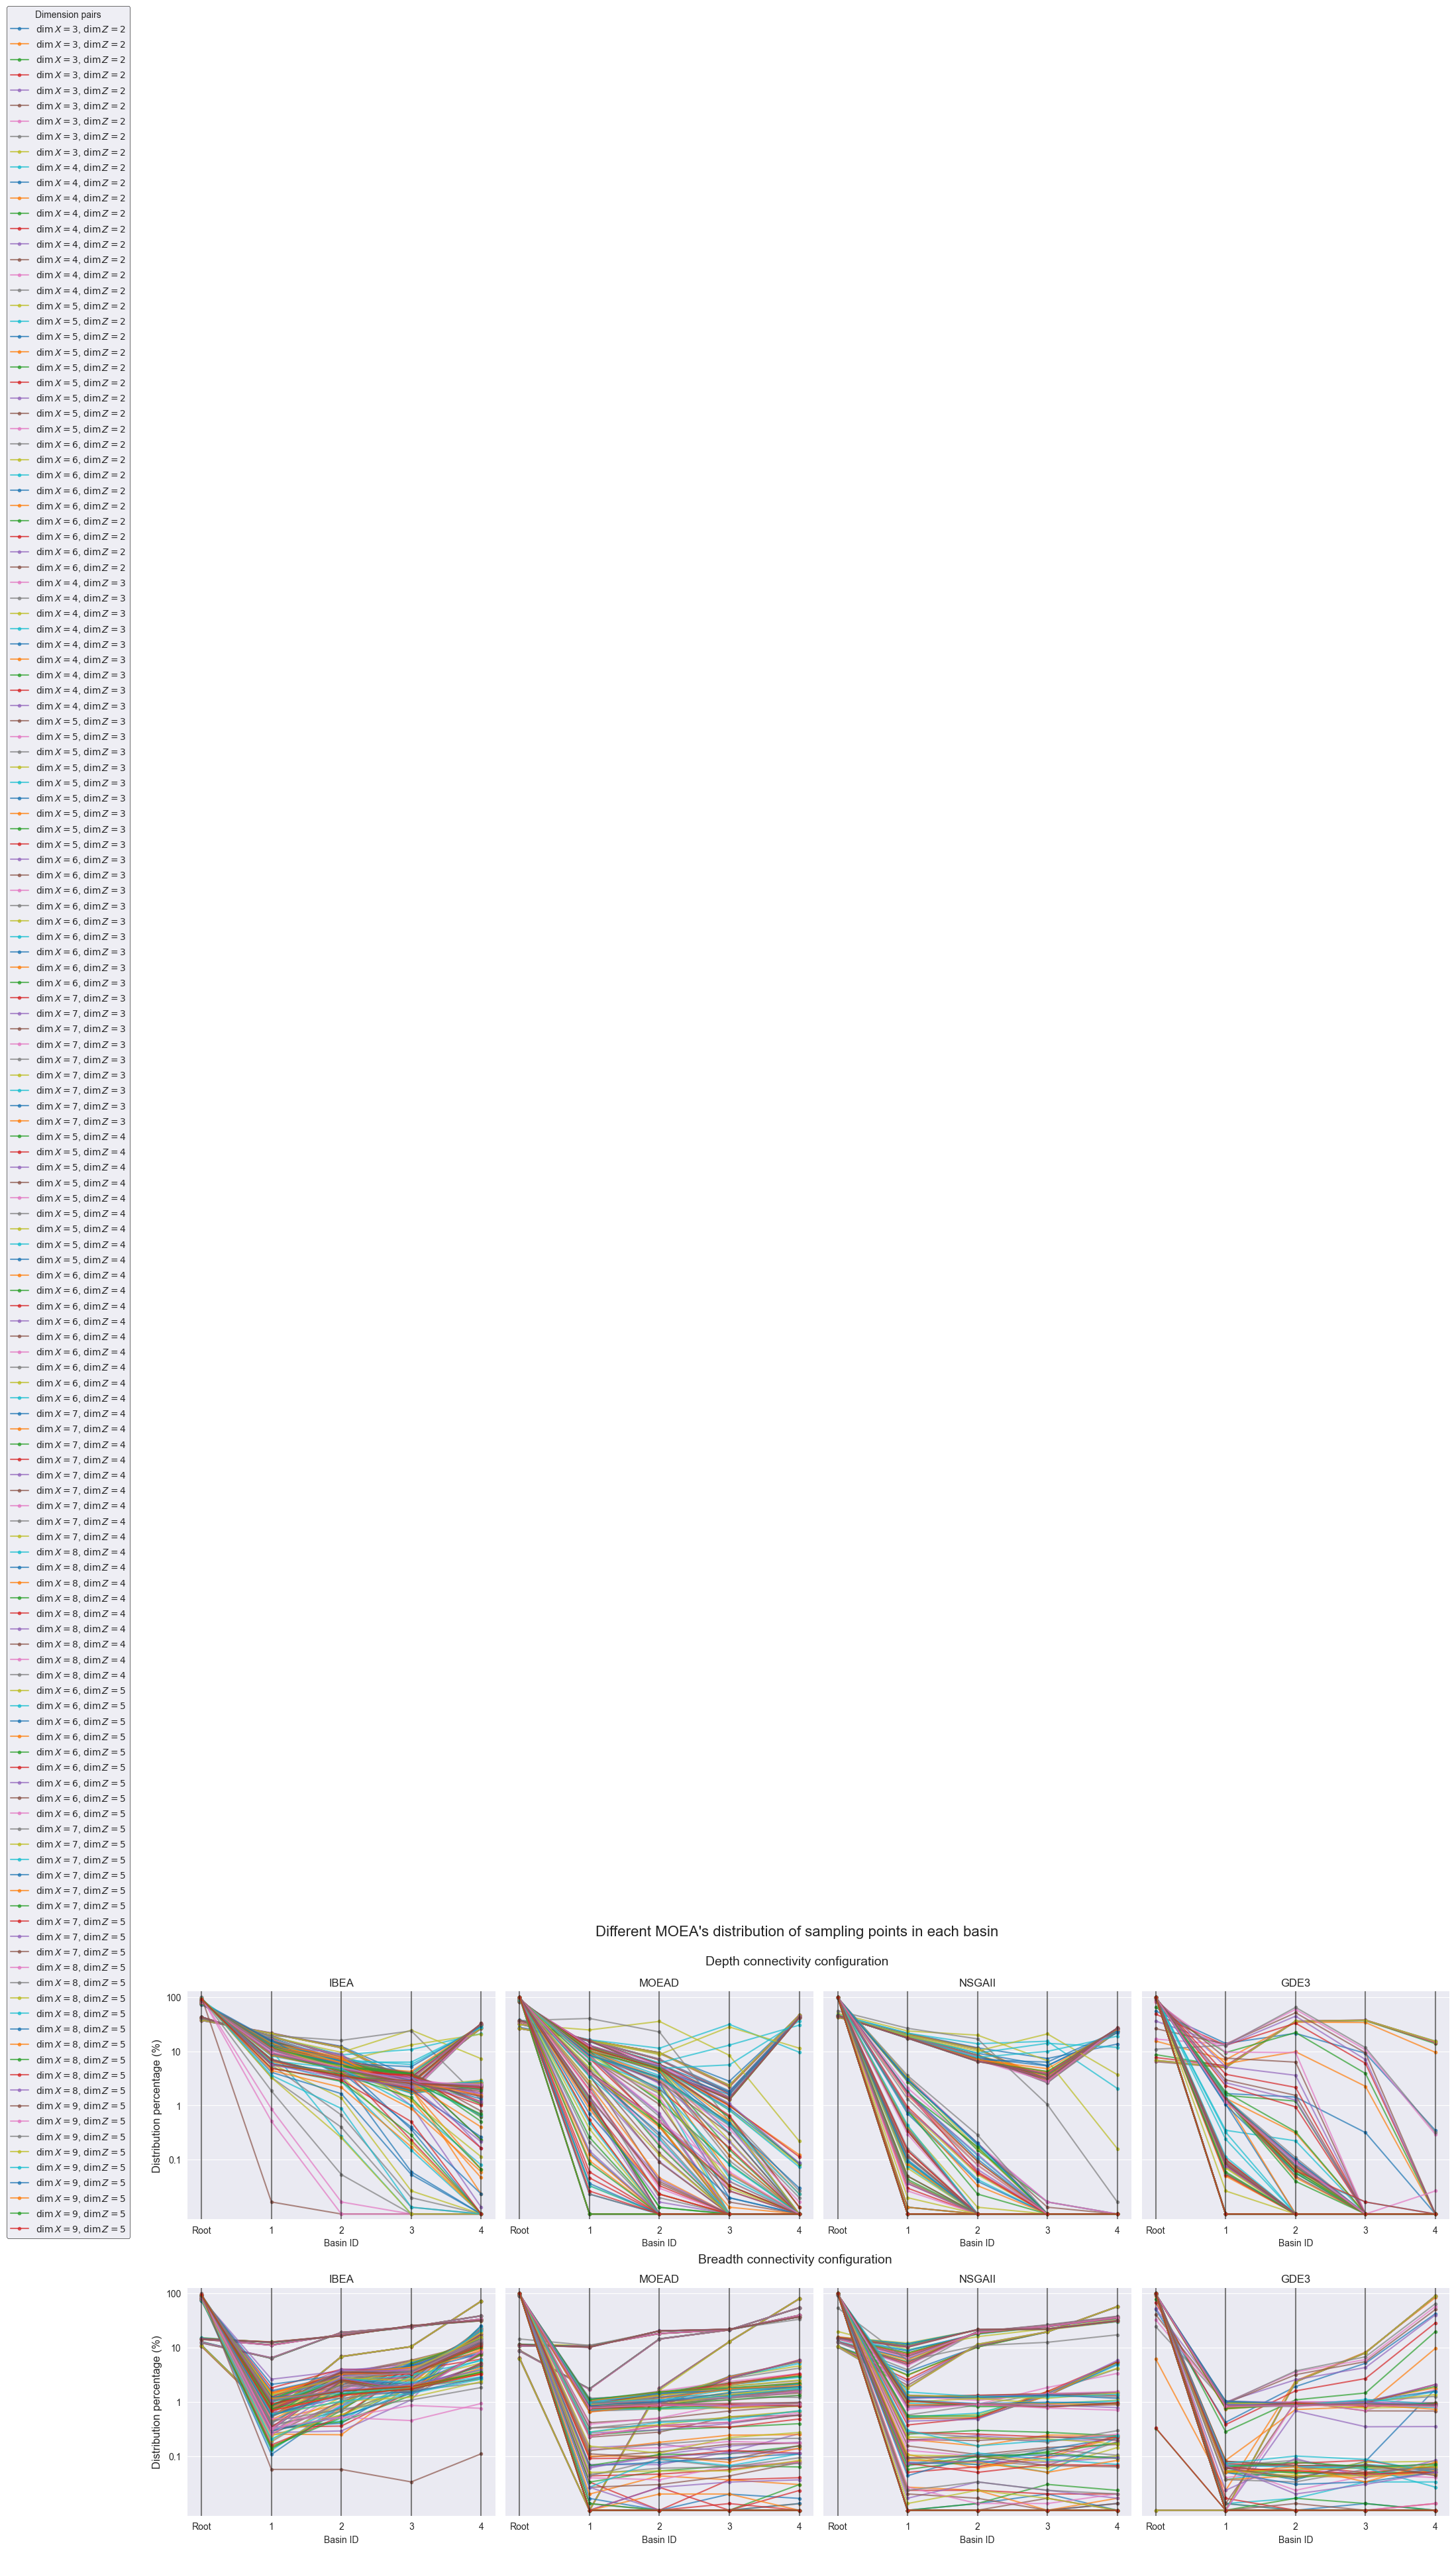

In [8]:
solvers = [
    "IBEA",
    "MOEAD",
    "NSGAII",
    "GDE3",
]
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axs = axs.ravel()

row_labels = []
row_label_flag = False
for i, ax in enumerate(axs):
    solver = solvers[i % 4]
    if i <= 3:
        tree = trees[0]
    else:
        tree = trees[1]
    plotting_df = stats_df[
        (stats_df["solver"] == solver) & (stats_df["tree"] == tree)
    ].copy()
    plotting_df["agg_dimX"] = plotting_df["dimX"] + plotting_df["dimZ"] - 1
    plotting_df.sort_values(
        by=["dimZ", "agg_dimX"], ascending=[True, True], inplace=True
    )
    plotting_df.reset_index(inplace=True)
    plotting_df_log = plotting_df[
        ["root_mean", "node_1_mean", "node_2_mean", "node_3_mean", "node_4_mean"]
    ]

    plotting_df_log = np.log10(
        plotting_df_log.replace(0, np.nan)
    )  # Log transform, avoiding log(0)

    plotting_df_log.fillna(-2, inplace=True)
    plotting_df_log.where(plotting_df_log > -2, -2, inplace=True)

    num_vars = len(plotting_df_log.columns)
    plotting_df_log["dimX"] = plotting_df["dimX"]
    plotting_df_log["dimZ"] = plotting_df["dimZ"]

    x = range(num_vars)

    for idx, row in plotting_df_log.iterrows():
        y = row.to_list()[:-2]
        row_label = f"$\operatorname{{dim}}X={int(row['dimX'] + row['dimZ'] - 1)}$, $\operatorname{{dim}}Z={int(row['dimZ'])}$"
        if not row_label_flag:
            row_labels.append(row_label)
        ax.plot(
            x, y, marker=".", label=row_label, alpha=0.7
        )  # Each line labeled with row label

    row_label_flag = True

    ax.set_title(solver)

    ax.set_xticks(ticks=x)
    ax.set_xticklabels(["Root", "1", "2", "3", "4"])  # Set the labels for each axis

    for j in x:
        ax.vlines(
            j, -2.1, 2.1, color="black", alpha=0.5
        )  # Extend the vertical lines based on log scale

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylim(-2.1, 2.1)  # Log10 of 0.1 is -1, and Log10 of 100 is 2
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_yticklabels([0.1, 1, 10, 100])
    ax.set_xlabel("Basin ID")

axs[0].set_ylabel("Distribution percentage (%)", fontsize=12)
axs[4].set_ylabel("Distribution percentage (%)", fontsize=12)

legend = fig.legend(
    title="Dimension pairs",
    labels=row_labels,
    loc="lower left",
    bbox_to_anchor=(-0.1, 0.5),
    frameon=True,
)
legend.get_frame().set_edgecolor("black")  # Set the edge color of the frame
legend.get_frame().set_linewidth(0.5)  # Set the line width of the frame

fig.suptitle(
    "Different MOEA's distribution of sampling points in each basin", fontsize=16
)
fig.text(
    0.5, 0.92, "Depth connectivity configuration", ha="center", fontsize=14
)  # Title for the first row
fig.text(
    0.5, 0.47, "Breadth connectivity configuration ", ha="center", fontsize=14
)  # Title for the second row

plt.tight_layout(
    rect=[0.05, 0.03, 1, 0.95]
)  # Adjust the layout to fit titles and legend
plt.subplots_adjust(
    left=0.04, hspace=0.3
)  # Adjust space to make room for the left legend
plt.savefig("log_parallel.pdf", format="pdf", bbox_inches="tight")

plt.show()

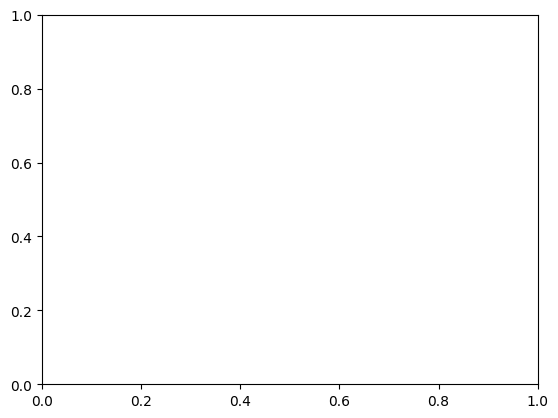

In [20]:
gens = [x * 100 for x in range(1, 10)]
gens = [800]
for gen in gens:
    solvers = ["IBEA", "MOEAD", "NSGAII", "GDE3"]

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True, dpi=600)
    axs = axs.ravel()

    row_labels = []
    row_label_flag = False

    for i, ax in enumerate(axs):
        solver = solvers[i % 4]
        if i <= 3:
            tree = trees[0]
        else:
            tree = trees[1]

        # Filter data for the specific solver and tree
        plotting_df = stats_df[
            (stats_df["solver"] == solver)
            & (stats_df["tree"] == tree)
            & (stats_df["gen"] == gen)
        ].copy()
        plotting_df["agg_dimX"] = plotting_df["dimX"] + plotting_df["dimZ"] - 1
        plotting_df.sort_values(
            by=["dimZ", "agg_dimX"], ascending=[True, True], inplace=True
        )
        plotting_df.reset_index(inplace=True)

        # Linear scale: Directly use the original data (no log transform)
        plotting_df_linear = plotting_df[
            ["root_mean", "node_1_mean", "node_2_mean", "node_3_mean", "node_4_mean"]
        ].copy()

        # Ensure no negative values or NaNs (if needed)
        plotting_df_linear.fillna(0, inplace=True)

        num_vars = len(plotting_df_linear.columns)
        plotting_df_linear["dimX"] = plotting_df["dimX"]
        plotting_df_linear["dimZ"] = plotting_df["dimZ"]

        x = range(num_vars)

        for idx, row in plotting_df_linear.iterrows():
            y = row.to_list()[:-2]  # Get the values without 'dimX' and 'dimZ'
            actual_dimX = int(row["dimX"] + row["dimZ"] - 1)
            if not (
                (row["dimZ"] == 2 and row["dimX"] in [5, 6]) or actual_dimX in [6, 7]
            ):
                continue
            row_label = f"$\operatorname{{dim}}X={int(row['dimX'] + row['dimZ'] - 1)}$, $\operatorname{{dim}}Z={int(row['dimZ'])}$"
            if not row_label_flag:
                row_labels.append(row_label)
            ax.plot(
                x, y, marker=".", label=row_label, alpha=0.7
            )  # Each line labeled with row label

        row_label_flag = True
        if solver == "MOEAD":
            solver_name = "MOEA/D"
        elif solver == "NSGAII":
            solver_name = "NSGA-II"
        else:
            solver_name = solver
        ax.set_title(solver_name)

        ax.set_xticks(ticks=x)
        ax.set_xticklabels(["Root", "1", "2", "3", "4"])  # Set the labels for each axis

        for j in x:
            ax.vlines(
                j, 0, 100, color="black", alpha=0.5
            )  # Extend the vertical lines (0 to 100 range for linear)

        # Adjust the axis appearance
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_ylim(-1, 100)  # Linear scale range (0 to 100)
        ax.set_yticks([0, 25, 50, 75, 100])  # Adjust y-axis ticks for linear scale
        ax.set_yticklabels([0, 25, 50, 75, 100])  # Linear scale labels (0 to 100)
        ax.set_xlabel("Basin ID")

    # Set y-axis labels for the first subplot of each row
    axs[0].set_ylabel("Distribution percentage (%)", fontsize=16)
    axs[4].set_ylabel("Distribution percentage (%)", fontsize=16)

    # Add the legend on the left with an outer frame
    legend = fig.legend(
        title="Dimension pairs",
        labels=row_labels,
        loc="lower left",
        bbox_to_anchor=(-0.1, 0.5),
        frameon=True,
    )
    legend.get_frame().set_edgecolor("black")  # Set the edge color of the frame
    legend.get_frame().set_linewidth(0.5)  # Set the line width of the frame

    # Add titles
    fig.suptitle(
        "Different MOEA's distribution of sampling points in each basin", fontsize=16
    )
    fig.text(
        0.5, 0.92, "Depth connectivity configuration", ha="center", fontsize=16
    )  # Title for the first row
    fig.text(
        0.5, 0.47, "Breadth connectivity configuration ", ha="center", fontsize=16
    )  # Title for the second row

    # Adjust layout to fit titles and legend
    plt.tight_layout(
        rect=[0.05, 0.03, 1, 0.95]
    )  # Adjust the layout to fit titles and legend
    plt.subplots_adjust(
        left=0.04, hspace=0.3
    )  # Adjust space to make room for the left legend
    #     plt.show()

    plt.savefig(
        f"gen_wise_parallel/linear_parallel_gen{gen}.pdf",
        format="pdf",
        bbox_inches="tight",
    )
    plt.savefig(f"gen_wise_parallel/linear_parallel_gen{gen}.png")
    plt.close("all")  # Closes all open figures
    plt.clf()  # Clears the current figure (if one exists)
    plt.cla()  # Clears the current axes (if any exist)